In [ ]:
# Created Virtual Environment 'virtualenv'

In [1]:
# Installing Pytorch and Numpy Library for the Model
!pip install torch torchvision numpy

     ---------------------------------------- 1.2/1.2 MB 4.7 MB/s eta 0:00:00
     -------------------------------------- 159.7/159.7 MB 2.7 MB/s eta 0:00:00
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl (228.5 MB)
  Using cached tbb-2021.12.0-py3-none-win_amd64.whl (286 kB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl (3.5 MB)
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2


ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [2]:
# Installing matplotlib for plotting & visualizations
!pip install matplotlib

In [4]:
# Importing all the necessary libraries
import gzip # unzipping the files
import numpy as np # Calculations
import pandas as pd # Preprocessing
import matplotlib.pyplot as plt # Plotting
import torch # Model
from torch.utils.data import DataLoader, Dataset

In [6]:
# Created EMNIST Class for the dataset processing
class EMNISTDataset(Dataset):
    def __init__(self, images_path, labels_path):
        self.images = self._read_images(images_path)
        self.labels = self._read_labels(labels_path)

    def _read_images(self, filepath):
        with gzip.open(filepath, 'rb') as f:
            f.read(16)
            data = np.frombuffer(f.read(), dtype=np.uint8)
            data = data.reshape(-1, 28, 28).astype(np.float32) / 255.0
            data = np.expand_dims(data, axis=1)
        return data

    def _read_labels(self, filepath):
        with gzip.open(filepath, 'rb') as f:
            f.read(8)
            data = np.frombuffer(f.read(), dtype=np.uint8)
        return data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [7]:
# Loading the  testing and training Datasets along with labels
train_dataset = EMNISTDataset('C:/Users/hp/OneDrive/Documents/GitHub/Handwritten-Digit-Recognition/Extended-MNIST-Dataset/emnist-byclass-train-images-idx3-ubyte.gz', 'C:/Users/hp/OneDrive/Documents/GitHub/Handwritten-Digit-Recognition/Extended-MNIST-Dataset/emnist-byclass-train-labels-idx1-ubyte.gz')
test_dataset = EMNISTDataset(r'C:\Users\hp\OneDrive\Documents\GitHub\Handwritten-Digit-Recognition\Extended-MNIST-Dataset\emnist-byclass-test-images-idx3-ubyte.gz', r'C:\Users\hp\OneDrive\Documents\GitHub\Handwritten-Digit-Recognition\Extended-MNIST-Dataset\emnist-byclass-test-labels-idx1-ubyte.gz')

In [8]:
# Batching the dataset using the inbiuld DataLoader constructor
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

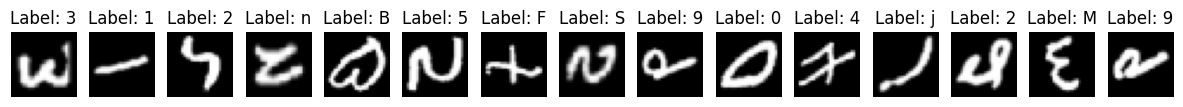

In [9]:
# Define the class labels for EMNIST dataset
class_labels = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

# Function to display images from the dataset
def display_images(images, labels, num_images=15):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f"Label: {class_labels[labels[i]]}")
        ax.axis('off')
    plt.show()

# Display some sample images from the training dataset
sample_images, sample_labels = next(iter(train_loader))
display_images(sample_images, sample_labels)

In [10]:
# Created LeNet5 Model CLass
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 62)  # EMNIST has 62 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet5()

In [11]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

train_model(model, train_loader, criterion, optimizer)

Epoch 1/10, Loss: 0.6255652816546372
Epoch 2/10, Loss: 0.43952416897970514
Epoch 3/10, Loss: 0.4134606642434406
Epoch 4/10, Loss: 0.40024909040571766
Epoch 5/10, Loss: 0.3919151665821505
Epoch 6/10, Loss: 0.38547487941828645
Epoch 7/10, Loss: 0.38140652499042277
Epoch 8/10, Loss: 0.3779028046998478
Epoch 9/10, Loss: 0.37493410683634104
Epoch 10/10, Loss: 0.37271742531461016


In [19]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total}%")

evaluate_model(model, test_loader)

Accuracy: 85.84200888904172%


In [20]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([6, 1, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 256])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([62, 84])
fc3.bias 	 torch.Size([62])


In [21]:
model_path = "lenet5_model.pth"

# Save the state dictionary
torch.save(model, model_path)
print(f"Model saved to {model_path}")

Model saved to lenet5_model.pth


In [23]:
# Assume `LeNet5` is your model class
model = LeNet5()
model_path = "lenet5_model.pth"

# Load the state dictionary
model = torch.load(model_path)

# Set the model to evaluation mode
model.eval()

print(f"Model loaded from {model_path}")

Model loaded from lenet5_model.pth


In [24]:
evaluate_model(model, test_loader)

Accuracy: 85.84200888904172%
